# Multi-agent Gathering Environment

In this notebook, we evolve the code from HumanCompatibleAI's single-agent version to full-fledged multi-agent reinforcement learning.

* 1st Iteration - Policy Gradient agent vs 1+ Random Agent
* 2nd iteration - Train Policy Gradient agent vs  1+ previously-trained PG agent
* 3rd iteration - Train multiple Policy Gradient agents together

We will implement the code changes in the Python files (.py) directly.

In [1]:
import os
import random
import time
import platform
import torch
import gym

from env import GatheringEnv   # This is the Game Environment
# from model import Policy   Use the Policy defined below instead

import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

print("Python version: ", platform.python_version())
print("Pytorch version: {}".format(torch.__version__))
print("OpenAI Gym version: {}".format(gym.__version__))

Python version:  3.6.4
Pytorch version: 0.2.0_3
OpenAI Gym version: 0.9.2


##  1st Iteration - Policy Gradient agent vs 1+ Random Agent

The HumanCompatibleAI's code only allows one agent to be trained in a Gathering environment with the other agents being random agents. This is because the weights are saved and loaded from a fixed single file.

To get the code to accept multiple trained agents, the Policy class has been changed to accept agent index and to allow each agent to save and load weights from its own model file. The code now expects each agent to have its own set of trained weights:

* agent-1-model.pkl
* agent-2-model.pkl
* etc....

In addition, we created the Rdn_Policy class to accommodate random agents.

In [2]:
import os
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable


class Policy(nn.Module):
    # an index parameter is needed to allow for multiple learning agents later
    def __init__(self, observation_size, agent_idx=1):
        super(Policy, self).__init__()
        self.affine1 = nn.Linear(observation_size, 128)
        self.affine2 = nn.Linear(128, 8)

        self.saved_actions = []
        self.rewards = []
        self.idx = agent_idx   # This allows multiple learning agents

    def forward(self, x):
        x = F.relu(self.affine1(x))
        action_scores = self.affine2(x)
        return F.softmax(action_scores)

    # The weights should be allowed to be saved into and load from agent-indexed model files
    # e.g. agent-1-model.pkl, agent-2-model.pkl, etc.
    def save_weights(self):
        file_name = 'agent-'+str(self.idx)+'-model.pkl'
        torch.save(self.state_dict(), file_name)   

    def load_weights(self):
        file_name = 'agent-'+str(self.idx)+'-model.pkl'
        if not os.path.exists(file_name):
                raise ValueError('map not found: ' + file_name)
        self.load_state_dict(torch.load(file_name))

    def select_action(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0)
        probs = self(Variable(state))
        action = probs.multinomial()
        self.saved_actions.append(action)
        return action.data[0, 0]


# Just a dumb random agent
class Rdn_Policy():
    def __init__(self):
        super(Rdn_Policy, self).__init__()

    def select_action(self, state):
        return random.randrange(0, 8)

## 1 PG agent vs multiple random agents

We get the code to run a PG agent against multiple random agents after making some change to GatheringEnv() Class.

In [3]:
# from model import *    # Use the Policy and Rdn_Policy classes instead

# There will be 4 agents - 1 AI agents, 3 random agents
num_ai_agents = 1
num_rdn_agents = 3
num_agents = num_ai_agents+num_rdn_agents  # just the sum of the two

# Data structure for AI agents (agents will form their own Class later on)
ai_agents = []
actions = []
tags = []
rewards = []

env = GatheringEnv(n_agents=num_agents, map_name='default')

# Env API is similar to that of OpenAI Gym
state_n = env.reset()
env.render()

# Load AI agents with trained weights
for i in range(num_ai_agents):
    print("Load agent {}".format(i))
    ai_agents.append(Policy(env.state_size, i+1))
    ai_agents[i].load_weights()
# Load random agents    
for i in range(num_ai_agents,num_agents):
    print("Load agent {}".format(i))
    ai_agents.append(Rdn_Policy())

# Initialize AI and random agent data
for i in range(num_agents):
    actions = [0 for i in range(num_agents)]
    tags = [0 for i in range(num_agents)]
    rewards = [0 for i in range(num_agents)]

n_steps = 300

# Render for n_steps steps
for step in range(n_steps):
    # Load AI agent with trained weights
    for i in range(num_agents):
        actions[i] = ai_agents[i].select_action(state_n[i])
        if actions[i] is 6:
            tags[i] += 1   # record a tag for accessing aggressiveness

    if step % 10 == 0:
        print (actions)    
            
    state_n, reward_n, done_n, info_n = env.step(actions)

    for i in range(num_agents):
        rewards[i] += reward_n[i]    # Accumulate rewards for each agent
        
    if any(done_n):
        break
    env.render()
    time.sleep(1/30)  # Change speed of video rendering

env.close()  # Close the rendering window

# Print out statistics of all agents
for i in range(num_agents):
    print ("Agent{} aggressiveness is {:.2f}".format(i+1, tags[i]/n_steps))
    print ("Agent{} reward is {:d}".format(i+1, rewards[i]))


Load agent 0
Load agent 1
Load agent 2
Load agent 3
[1, 3, 2, 3]
[3, 4, 1, 7]
[2, 6, 6, 0]
[6, 5, 3, 0]
[0, 7, 0, 2]
[1, 0, 6, 1]
[3, 2, 6, 0]
[1, 0, 1, 6]
[0, 7, 2, 6]
[6, 5, 1, 7]
[1, 3, 3, 6]
[2, 6, 0, 6]
[2, 4, 6, 4]
[2, 3, 5, 5]
[2, 7, 7, 0]
[2, 2, 5, 7]
[3, 5, 4, 6]
[3, 0, 5, 5]
[6, 3, 7, 6]
[0, 5, 4, 4]
[2, 1, 3, 0]
[2, 4, 4, 5]
[2, 3, 4, 3]
[2, 2, 0, 5]
[3, 1, 1, 3]
[1, 6, 7, 5]
[1, 3, 0, 4]
[1, 3, 7, 7]
[3, 6, 3, 7]
[5, 1, 0, 1]
Agent1 aggressiveness is 0.10
Agent1 reward is 114
Agent2 aggressiveness is 0.10
Agent2 reward is 0
Agent3 aggressiveness is 0.12
Agent3 reward is 0
Agent4 aggressiveness is 0.15
Agent4 reward is 0


## Multi-agents with previously trained weights

When we load 3 previously trained PG agents, and they play well against the 2 random agents and each other.

In [7]:
from model import *    # Use the Policy and Rdn_policy defined in model.py

# There will be 5 agents - 3 AI agents, 2 random agents
num_ai_agents = 3
num_rdn_agents = 2
num_agents = num_ai_agents+num_rdn_agents  # just the sum of the two

# Data structure for AI agents (agents will form their own Class later on)
ai_agents = []
actions = []
tags = []
rewards = []

env = GatheringEnv(n_agents=num_agents, map_name='default')

# Env API is similar to that of OpenAI Gym
state_n = env.reset()
env.render()

# Load AI agents with trained weights
for i in range(num_ai_agents):
    print("Load agent {}".format(i))
    ai_agents.append(Policy(env.state_size, i+1))
    ai_agents[i].load_weights()
# Load random agents    
for i in range(num_ai_agents,num_agents):
    print("Load agent {}".format(i))
    ai_agents.append(Rdn_Policy())

# Initialize AI and random agent data
for i in range(num_agents):
    actions = [0 for i in range(num_agents)]
    tags = [0 for i in range(num_agents)]
    rewards = [0 for i in range(num_agents)]

n_steps = 300

# Render for n_steps steps
for step in range(n_steps):
    # Load AI agent with trained weights
    for i in range(num_agents):
        actions[i] = ai_agents[i].select_action(state_n[i])
        if actions[i] is 6:
            tags[i] += 1   # record a tag for accessing aggressiveness

    if step % 10 == 0:
        print (actions)    
            
    state_n, reward_n, done_n, info_n = env.step(actions)

    for i in range(num_agents):
        rewards[i] += reward_n[i]    # Accumulate rewards for each agent
        
    if any(done_n):
        break
    env.render()
    time.sleep(1/30)  # Change speed of video rendering

env.close()  # Close the rendering window

# Print out statistics of all agents
for i in range(num_agents):
    print ("Agent{} aggressiveness is {:.2f}".format(i+1, tags[i]/n_steps))
    print ("Agent{} reward is {:d}".format(i+1, rewards[i]))


Load agent 0
Load agent 1
Load agent 2
Load agent 3
Load agent 4
[2, 6, 1, 2, 4]
[0, 0, 3, 3, 7]
[0, 0, 0, 3, 4]
[0, 2, 1, 3, 2]
[3, 0, 0, 1, 7]
[6, 6, 4, 7, 3]
[2, 1, 1, 2, 0]
[0, 6, 0, 4, 0]
[5, 6, 0, 5, 3]
[0, 3, 6, 1, 4]
[3, 1, 1, 5, 4]
[0, 2, 1, 0, 7]
[2, 6, 1, 5, 2]
[0, 1, 4, 5, 6]
[0, 0, 0, 7, 6]
[6, 1, 0, 5, 3]
[6, 1, 2, 6, 3]
[6, 1, 3, 6, 3]
[5, 1, 3, 0, 2]
[0, 4, 1, 7, 6]
[3, 7, 1, 3, 7]
[0, 2, 4, 5, 3]
[6, 4, 6, 6, 7]
[3, 7, 4, 5, 3]
[6, 4, 0, 5, 4]
[1, 0, 1, 4, 1]
[0, 0, 5, 2, 2]
[3, 0, 0, 0, 4]
[3, 1, 4, 5, 2]
[2, 3, 6, 3, 5]
Agent1 aggressiveness is 0.12
Agent1 reward is 7
Agent2 aggressiveness is 0.13
Agent2 reward is 47
Agent3 aggressiveness is 0.14
Agent3 reward is 19
Agent4 aggressiveness is 0.09
Agent4 reward is 0
Agent5 aggressiveness is 0.10
Agent5 reward is 0


## Iteration 2 - Train PG agent vs 1+ previously-trained PG agent

We train a PG agent in a multi-agent environment with previously trained PG agents. These previously trained PG agents will not learn during the training, their policies are thus **static**.

To allow for the training multiple learning agents, finish_episode() will need to be modified to be able to backprop on the parameters of multiple agents. We will save this for the next exercise.

In [17]:
# Adapted from https://github.com/pytorch/examples/blob/2dca104/reinforcement_learning/reinforce.py
# Licensed under BSD 3-clause: https://github.com/pytorch/examples/blob/2dca10404443ce3178343c07ba6e22af13efb006/LICENSE

import random
from itertools import count

from env import GatheringEnv
from model import *    # Use the Policy and Rdn_policy defined in model.py

import numpy as np

import torch
import torch.autograd as autograd
import torch.optim as optim

# We remove the argparse code and replace with hard parameters
gamma = 0.99
seed = 543
render=False
log_interval=20
target_reward = 500

# There will be 4 agents - 1 learning agents, 3 static agents
num_learners = 1
num_statics = 3
num_agents = num_learners+num_statics  # just the sum of the two

# Data structure for agents (learning and static)
agents = []
actions = []
tags = []
rewards = []

# Start the Gathering environment
env = GatheringEnv(n_agents=num_agents, map_name='default')
env.seed(seed)
torch.manual_seed(seed)

# Initialize learner agents
for i in range(num_learners):
    print("Learner agent {}".format(i+1))
    agents.append(Policy(env.state_size, i+1))  # No weights loaded

# Load static agents
for i in range(num_learners, num_agents):
    print("Load static agent {}".format(i+1))
    agents.append(Policy(env.state_size, i+1))
    agents[i].load_weights()
    
# Initialize all agent data
for i in range(num_agents):
    actions = [0 for i in range(num_agents)]
    tags = [0 for i in range(num_agents)]
    rewards = [0 for i in range(num_agents)]
    
learners_params = agents[0].parameters()   # For now, there is only 1 learner
# For multiple learning agents later on, replace with
# params = list(fc1.parameters()) + list(fc2.parameters())

optimizer = optim.Adam(learners_params, lr=1e-3)   # Only agent 1 will learn

# This is the task list to finish a game episode
def finish_episode():
    """ 
    Based on REINFORCE, policy gradient is calculated at the end of an episode.
    It is then used to update the Policy's weights
    """
    
    # Our code only accommodates 1 learning agent.
    # Reward for each time step is stored in the list policy.rewards[] --> r(t)
    R = 0  # noqa
    rewards = []
    for r in agents[0].rewards[::-1]:
        R = r + gamma * R  # noqa
        rewards.insert(0, R)
    rewards = torch.Tensor(rewards)
    rewards = (rewards - rewards.mean()) / (rewards.std() + np.finfo(np.float32).eps)
    
    # Calculate policy gradient Σ_t[r(t) ∇_θ log(π_θ(s_t,a_t))
    for action, r in zip(agents[0].saved_actions, rewards):
        action.reinforce(r)     # Note that action.reinforce has been deprecated since torch V0.3
    optimizer.zero_grad()
    autograd.backward(agents[0].saved_actions, [None for _ in agents[0].saved_actions])
    optimizer.step()
    
    del agents[0].rewards[:]
    del agents[0].saved_actions[:]


# Keep track of rewards learned by learners
running_reward = [0 for i in range(num_learners)]   # running average
best_reward = [0 for i in range(num_learners)]    # best running average for storing best_model
episode_reward = [0 for i in range(num_learners)]   # reward for an episode

for i_episode in range(1,1001):   # For each game episode
    
    # Some basic initialization
    state = env.reset()
    for i in range(num_learners):
        episode_reward[i] = 0   # initialize episode rewards for learners
    
    for t in range(1000):  # Don't infinite loop while learning
        
        # 1. learning and static agents select their action
        for i in range(num_agents):
            actions[i] = agents[i].select_action(state[i])
            if actions[i] is 6:
                tags[i] += 1   # record a tag for accessing aggressiveness
       
        # 2. environment accepts action from learning and static agents and 
        # doles out next state, reward and if the episode is done
        state_n, reward_n, done_n, _ = env.step(actions)
        
        state = state_n
        done = done_n[0]
        
        if render:   # render learning if set to True
            env.render()
            
        # For learner agents only, generate reward statistics and reward stack for REINFORCE
        for i in range(num_learners):
            agents[i].rewards.append(reward_n[i])  # Stack rewards for REINFORCE
            episode_reward[i] += reward_n[i]   # accumulate episode reward 
        
        if done:
            break

    # Update reward statistics for learners
    for i in range(num_learners):
        if running_reward[i] is None:
            running_reward[i] = episode_reward[i]
        running_reward[i] = running_reward[i] * 0.99 + episode_reward[i] * 0.01
    
    finish_episode()    # Finish up game episode
        
    if i_episode % log_interval == 0:
        print('Episode {}:'.format(i_episode))
        for i in range(num_learners):
            # Display reward stats for learners
            print('Learner {}\tLast reward: {:5d}\tAverage reward: {:.2f}'.format(
            i, episode_reward[i], running_reward[i]))
            
            # Only save NN weights if running_reward is better than best_reward
            if best_reward[i]is None:
                best_reward[i] = running_reward[i]
                agents[i].save_weights()   # Save NN weights for learner if this is the first save
            else:
                if running_reward[i] > best_reward[i]:
                    agents[i].save_weights()   # Save NN weights for learner only if it performs better
        
env.close()  # Close the rendering window

Learner agent 0
Load static agent 1
Load static agent 2
Load static agent 3
Episode 20:
Learner 0	Last reward:     0	Average reward: 0.06
Episode 40:
Learner 0	Last reward:     0	Average reward: 0.13
Episode 60:
Learner 0	Last reward:     1	Average reward: 0.25
Episode 80:
Learner 0	Last reward:     0	Average reward: 0.25
Episode 100:
Learner 0	Last reward:     0	Average reward: 0.29
Episode 120:
Learner 0	Last reward:     0	Average reward: 0.28
Episode 140:
Learner 0	Last reward:     0	Average reward: 0.37
Episode 160:
Learner 0	Last reward:     1	Average reward: 0.67
Episode 180:
Learner 0	Last reward:    11	Average reward: 1.94
Episode 200:
Learner 0	Last reward:    34	Average reward: 5.11
Episode 220:
Learner 0	Last reward:    50	Average reward: 9.03
Episode 240:
Learner 0	Last reward:    37	Average reward: 13.92
Episode 260:
Learner 0	Last reward:    54	Average reward: 21.07
Episode 280:
Learner 0	Last reward:    60	Average reward: 28.82
Episode 300:
Learner 0	Last reward:    62	A

## Play - Newly Trained PG1 vs Trained PG2-4

We now play the newly trained PG agents against the 3 previously-trained PG agents it was trained against.
    
The newly trained agent (Agent 1) is able to overpower the other 3 agents, but not being overly aggressive.

Agent1 aggressiveness is 0.09  
Agent1 reward is 138  
Agent2 aggressiveness is 0.13  
Agent2 reward is 55  
Agent3 aggressiveness is 0.12  
Agent3 reward is 53  
Agent4 aggressiveness is 0.13  
Agent4 reward is 22  

It appears to always tag to the right when the other 3 agents are within his sight.

In [37]:
from model import *    # Use the Policy and Rdn_policy defined in model.py

# There will be 4 agents - 3 AI agents, 1 random agent
num_ai_agents = 3
num_rdn_agents = 1
num_agents = num_ai_agents+num_rdn_agents  # just the sum of the two

# Data structure for AI agents (agents will form their own Class later on)
ai_agents = []
actions = []
tags = []
rewards = []

env = GatheringEnv(n_agents=num_agents, map_name='default')

# Env API is similar to that of OpenAI Gym
state_n = env.reset()
env.render()

# Load AI agents with trained weights
for i in range(num_ai_agents):
    print("Load agent {}".format(i))
    ai_agents.append(Policy(env.state_size, i+1))
    ai_agents[i].load_weights()
# Load random agents    
for i in range(num_ai_agents,num_agents):
    print("Load agent {}".format(i))
    ai_agents.append(Rdn_Policy())

# Initialize AI and random agent data
for i in range(num_agents):
    actions = [0 for i in range(num_agents)]
    tags = [0 for i in range(num_agents)]
    rewards = [0 for i in range(num_agents)]

n_steps = 1000

# Render for n_steps steps
for step in range(n_steps):
    # Load AI agent with trained weights
    for i in range(num_agents):
        actions[i] = ai_agents[i].select_action(state_n[i])
        if actions[i] is 6:
            tags[i] += 1   # record a tag for accessing aggressiveness

    if step % 10 == 0:
        print (actions)    
            
    state_n, reward_n, done_n, info_n = env.step(actions)

    for i in range(num_agents):
        rewards[i] += reward_n[i]    # Accumulate rewards for each agent
        
    if any(done_n):
        break
    env.render()
    time.sleep(1/30)  # Change speed of video rendering

env.close()  # Close the rendering window

# Print out statistics of all agents
for i in range(num_agents):
    print ("Agent{} aggressiveness is {:.2f}".format(i+1, tags[i]/n_steps))
    print ("Agent{} reward is {:d}".format(i+1, rewards[i]))


Load agent 0
Load agent 1
Load agent 2
Load agent 3
[4, 4, 5, 4]
[1, 0, 0, 2]
[0, 5, 1, 5]
[1, 0, 0, 4]
[1, 0, 0, 6]
[0, 1, 0, 7]
[1, 0, 2, 4]
[1, 0, 1, 3]
[4, 2, 0, 2]
[4, 0, 0, 0]
[6, 0, 0, 0]
[0, 3, 0, 5]
[4, 2, 4, 1]
[3, 0, 0, 1]
[1, 0, 0, 3]
[1, 0, 0, 6]
[1, 0, 7, 4]
[2, 0, 4, 2]
[1, 0, 0, 0]
[3, 5, 0, 3]
[4, 0, 0, 7]
[7, 1, 1, 4]
[0, 0, 5, 4]
[0, 0, 3, 7]
[1, 0, 0, 2]
[1, 1, 0, 2]
[7, 0, 6, 7]
[1, 0, 0, 7]
[0, 0, 1, 4]
[0, 0, 0, 2]
[3, 1, 0, 1]
[1, 0, 0, 4]
[1, 6, 1, 1]
[7, 0, 0, 0]
[4, 7, 0, 6]
[1, 0, 5, 4]
[0, 5, 6, 1]
[7, 0, 7, 7]
[7, 0, 0, 5]
[1, 0, 1, 4]
[1, 3, 0, 7]
[0, 7, 0, 6]
[0, 5, 5, 6]
[0, 0, 0, 1]
[0, 4, 6, 7]
[4, 0, 0, 1]
[4, 0, 1, 0]
[1, 0, 5, 6]
[0, 0, 5, 1]
[0, 1, 1, 5]
[2, 0, 0, 7]
[1, 0, 0, 6]
[6, 0, 0, 1]
[0, 0, 0, 7]
[1, 1, 6, 5]
[1, 0, 0, 5]
[0, 4, 0, 3]
[3, 0, 1, 1]
[4, 5, 0, 1]
[1, 0, 0, 0]
[1, 5, 0, 2]
[5, 6, 0, 3]
[3, 6, 0, 3]
[1, 3, 0, 0]
[4, 5, 5, 3]
[0, 0, 0, 3]
[0, 1, 0, 6]
[0, 1, 0, 1]
[1, 1, 0, 1]
[0, 1, 0, 2]
[3, 1, 0, 1]
[5, 1, 0, 4]
[6, 0, 6, 1]

## Play - Enable Multi-agent Training



In [34]:
import random
from itertools import count

from env import GatheringEnv
from model import *    # Use the Policy and Rdn_policy defined in model.py

import numpy as np

import torch
import torch.autograd as autograd
import torch.optim as optim

# We remove the argparse code and replace with hard parameters
gamma = 0.99
seed = 543
render=False
log_interval=20
target_reward = 500

# There will be 4 agents - 2 learning agents, 2 static agents
num_learners = 2
num_statics = 2
num_agents = num_learners+num_statics  # just the sum of the two

# Data structure for agents (learning and static)
agents = []
actions = []
tags = []
rewards = []

# Data structure for training
optimizers = []

# Start the Gathering environment
env = GatheringEnv(n_agents=num_agents, map_name='default')
env.seed(seed)
torch.manual_seed(seed)

# Initialize learner agents, then load static agents
for i in range(num_learners):
    print("Learner agent {}".format(i+1))
    agents.append(Policy(env.state_size, i+1))  # No weights loaded for learning agent
    optimizers.append(optim.Adam(agents[i].parameters(), lr=1e-3))  # set up optimizer

for i in range(num_learners, num_agents):
    print("Load static agent {}".format(i+1))
    agents.append(Policy(env.state_size, i+1))
    agents[i].load_weights()         # load weight for static agent
    
# Initialize all agent data
for i in range(num_agents):
    actions = [0 for i in range(num_agents)]
    tags = [0 for i in range(num_agents)]
    rewards = [0 for i in range(num_agents)]

    
# This is the task list to finish a game episode
def finish_episode():
    """ 
    Based on REINFORCE, policy gradient is calculated at the end of an episode.
    It is then used to update the Policy's weights
    """
    
    # Our code will perform REINFORCE on each learning agent independently. 
    # Reward for each time step is stored in the list policy.rewards[] --> r(t)
    
    for i in range(num_learners):
        # print("REINFORCE agent {}".format(i+1))
        R = 0  # noqa
        rewards = []
        for r in agents[i].rewards[::-1]:
            R = r + gamma * R  # noqa
            rewards.insert(0, R)
        rewards = torch.Tensor(rewards)
        rewards = (rewards - rewards.mean()) / (rewards.std() + np.finfo(np.float32).eps)
    
        # Calculate policy gradient Σ_t[r(t) ∇_θ log(π_θ(s_t,a_t))
        for action, r in zip(agents[i].saved_actions, rewards):
            action.reinforce(r)     # Note that action.reinforce has been deprecated since torch V0.3
        optimizers[i].zero_grad()
        autograd.backward(agents[i].saved_actions, [None for _ in agents[i].saved_actions])
        optimizers[i].step()
    
        del agents[i].rewards[:]
        del agents[i].saved_actions[:]


# Keep track of rewards learned by learners
episode_reward = [0 for i in range(num_learners)]   # reward for an episode
running_reward = [0 for i in range(num_learners)]   # running average
best_reward = [0 for i in range(num_learners)]    # best running average (for storing best_model)


for i_episode in range(1,2001):   # For each game episode
    
    # Some basic initialization
    state = env.reset()
    for i in range(num_learners):
        episode_reward[i] = 0   # initialize episode rewards for learners
    
    for t in range(2001):  # Don't infinite loop while learning
        
        # 1. learning and static agents select their action
        for i in range(num_agents):
            actions[i] = agents[i].select_action(state[i])
            if actions[i] is 6:
                tags[i] += 1   # record a tag for accessing aggressiveness
       
        # 2. environment accepts action from learning and static agents and 
        # doles out next state, reward and if the episode is done
        state_n, reward_n, done_n, _ = env.step(actions)
        
        state = state_n    # Go to next state
        done = done_n[0]   # All agents have the same value for done_n
        
        if render:   # render learning if set to True
            env.render()
            
        # For learner agents only, generate reward statistics and stack for REINFORCE
        for i in range(num_learners):
            agents[i].rewards.append(reward_n[i])  # Stack rewards (for REINFORCE)
            episode_reward[i] += reward_n[i]   # accumulate episode reward 
        
        if done:
            break

    # Update reward statistics for learners
    for i in range(num_learners):
        if running_reward[i] is None:
            running_reward[i] = episode_reward[i]
        running_reward[i] = running_reward[i] * 0.99 + episode_reward[i] * 0.01
    
    finish_episode()    # Finish up game episode
        
    if i_episode % log_interval == 0:
        print('Episode {}:'.format(i_episode))
        for i in range(num_learners):
            # Display reward stats for learners
            print('Learner {}\tLast reward: {:5d}\tAverage reward: {:.2f}'.format(
            i, episode_reward[i], running_reward[i]))
            
            # Only save NN weights if running_reward is better than best_reward
            if best_reward[i]is None:
                best_reward[i] = running_reward[i]
                agents[i].save_weights()   # Save NN weights for learner if this is the first save
            else:
                if running_reward[i] > best_reward[i]:
                    agents[i].save_weights()   # Save NN weights for learner only if it performs better
        
env.close()  # Close the rendering window

Learner agent 1
Learner agent 2
Load static agent 3
Load static agent 4
Episode 20:
Learner 0	Last reward:     0	Average reward: 0.05
Learner 1	Last reward:     0	Average reward: 0.10
Episode 40:
Learner 0	Last reward:     0	Average reward: 0.20
Learner 1	Last reward:     0	Average reward: 0.15
Episode 60:
Learner 0	Last reward:     0	Average reward: 0.35
Learner 1	Last reward:     6	Average reward: 0.22
Episode 80:
Learner 0	Last reward:     0	Average reward: 0.47
Learner 1	Last reward:     0	Average reward: 0.20
Episode 100:
Learner 0	Last reward:     0	Average reward: 0.55
Learner 1	Last reward:     0	Average reward: 0.25
Episode 120:
Learner 0	Last reward:     7	Average reward: 1.01
Learner 1	Last reward:     0	Average reward: 0.35
Episode 140:
Learner 0	Last reward:     3	Average reward: 1.39
Learner 1	Last reward:     0	Average reward: 0.68
Episode 160:
Learner 0	Last reward:    19	Average reward: 4.09
Learner 1	Last reward:    14	Average reward: 1.55
Episode 180:
Learner 0	Last 

## Play - 2 Newly Trained PG1 vs Trained PG3 va Rdn4

We now play the 2 newly trained PG agents against the 1 previously-trained PG agents and a random agent
    
These newly trained agents (Agent 1 and 2) are super aggressive.

Agent1 aggressiveness is 0.24  
Agent1 reward is 107  
Agent2 aggressiveness is 0.27  
Agent2 reward is 195  
Agent3 aggressiveness is 0.13  
Agent3 reward is 17  
Agent4 aggressiveness is 0.13  
Agent4 reward is 0  

They seem to have learned the following techniques:
* Fire to the right to clear the path of other agents
* Get to the food cluster and munch in a loop 
* Fire laser repeatedly to the left when they are facing left

In [3]:
from model import *    # Use the Policy and Rdn_policy defined in model.py

# There will be 4 agents - 3 AI agents, 1 random agent
num_ai_agents = 3
num_rdn_agents = 1
num_agents = num_ai_agents+num_rdn_agents  # just the sum of the two

# Data structure for AI agents (agents will form their own Class later on)
ai_agents = []
actions = []
tags = []
rewards = []

env = GatheringEnv(n_agents=num_agents, map_name='default')

# Env API is similar to that of OpenAI Gym
state_n = env.reset()
env.render()

# Load AI agents with trained weights
for i in range(num_ai_agents):
    print("Load agent {}".format(i))
    ai_agents.append(Policy(env.state_size, i+1))
    ai_agents[i].load_weights()
# Load random agents    
for i in range(num_ai_agents,num_agents):
    print("Load agent {}".format(i))
    ai_agents.append(Rdn_Policy())

# Initialize AI and random agent data
for i in range(num_agents):
    actions = [0 for i in range(num_agents)]
    tags = [0 for i in range(num_agents)]
    rewards = [0 for i in range(num_agents)]

n_steps = 100

# Render for n_steps steps
for step in range(n_steps):
    # Load AI agent with trained weights
    for i in range(num_agents):
        actions[i] = ai_agents[i].select_action(state_n[i])
        if actions[i] is 6:
            tags[i] += 1   # record a tag for accessing aggressiveness

    if step % 10 == 0:
        print (actions)    
            
    state_n, reward_n, done_n, info_n = env.step(actions)

    for i in range(num_agents):
        rewards[i] += reward_n[i]    # Accumulate rewards for each agent
        
    if any(done_n):
        break
    env.render()
    time.sleep(1/30)  # Change speed of video rendering

env.close()  # Close the rendering window

# Print out statistics of all agents
for i in range(num_agents):
    print ("Agent{} aggressiveness is {:.2f}".format(i+1, tags[i]/n_steps))
    print ("Agent{} reward is {:d}".format(i+1, rewards[i]))


Load agent 0
Load agent 1
Load agent 2
Load agent 3
[4, 4, 5, 2]
[0, 2, 6, 7]
[0, 6, 6, 3]
[1, 6, 0, 3]
[0, 4, 2, 0]
[6, 6, 2, 6]
[0, 1, 0, 6]
[4, 1, 0, 1]
[4, 1, 0, 6]
[0, 1, 5, 2]
Agent1 aggressiveness is 0.30
Agent1 reward is 30
Agent2 aggressiveness is 0.15
Agent2 reward is 0
Agent3 aggressiveness is 0.18
Agent3 reward is 0
Agent4 aggressiveness is 0.15
Agent4 reward is 0


In [157]:
a = [[1,1,1]]
b = [[2,2,2]]
c = [[3,3,3]]
d = [[4,4,4]]

full_state = np.stack([a,b,c,d], axis=-1)
print (full_state)

full_state[:,1,:]=0
print (full_state)

full_state[:,:,2]=0
print (full_state)

[[[1 2 3 4]
  [1 2 3 4]
  [1 2 3 4]]]
[[[1 2 3 4]
  [0 0 0 0]
  [1 2 3 4]]]
[[[1 2 0 4]
  [0 0 0 0]
  [1 2 0 4]]]


## Figuring "Getting Stuck" Problem

In the scenario where we put 3 AI agents (loaded with the same policy network), they have a tendency to get stuck. As witnessed in the scenario below.

We believe this is because they have been originally trained against a single random agent, and therefore does not know how to avoid each other.

800
[(35, 25), (35, 26), (35, 27)]
[2, 1, 0]
(71, 51)


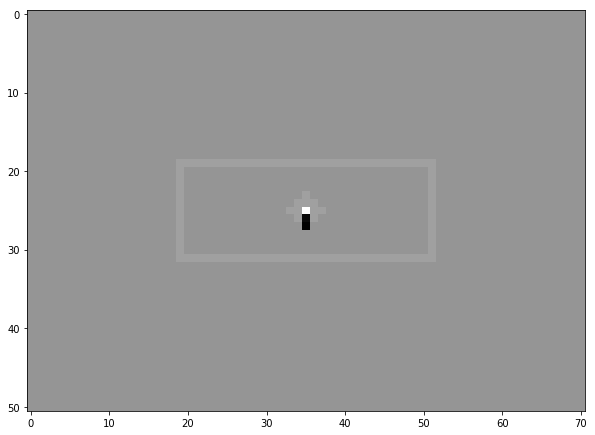

(3, 800)
Agent 1's Observation Space:
Agent 1's Orientation: DOWN
Agent 1's Action: UP
Agent 1's Location: 35,25


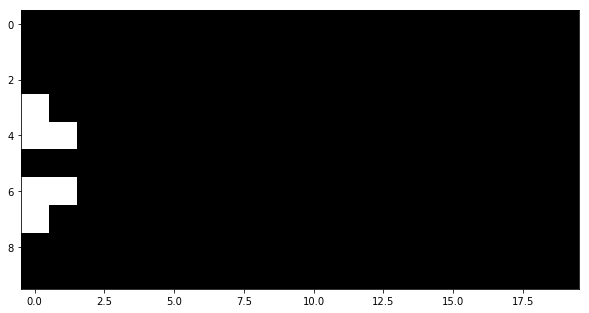

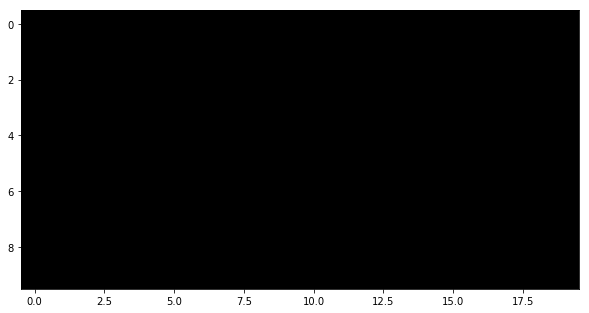

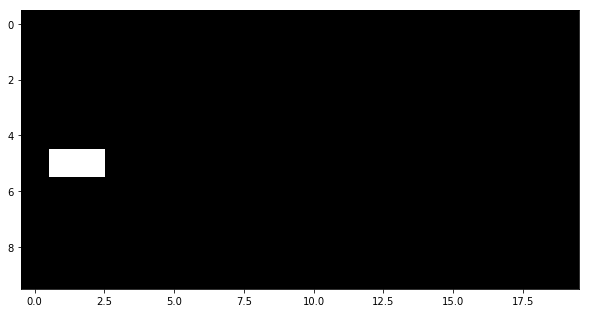

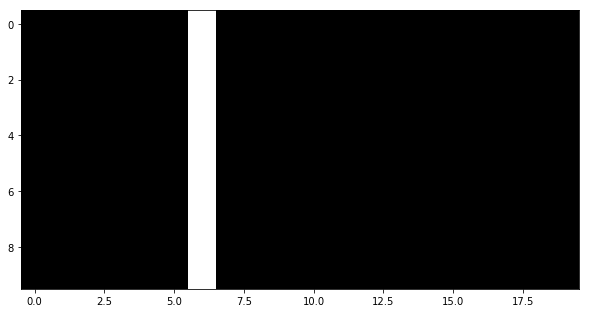

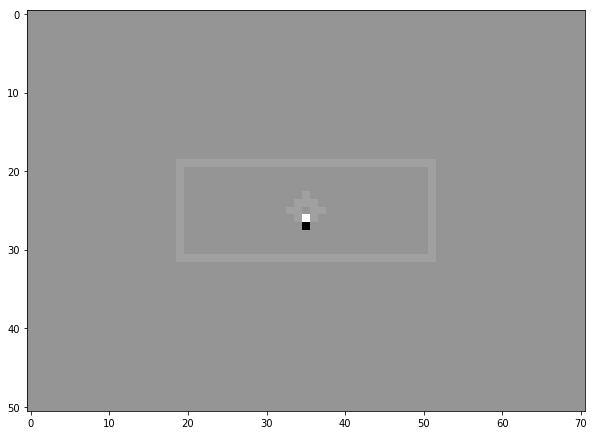

Agent 2's Observation Space:
Agent 2's Orientation: RIGHT
Agent 2's Action: RIGHT
Agent 2's Location: 35,26


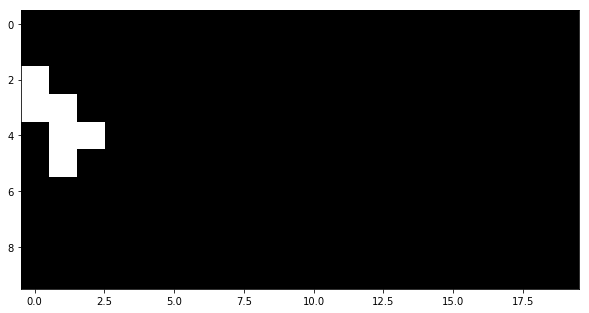

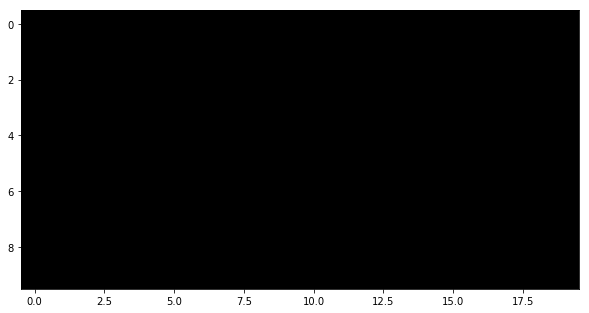

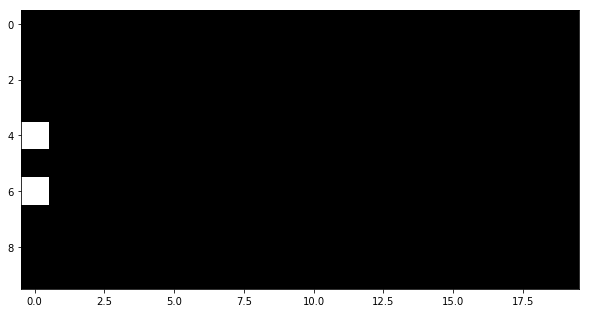

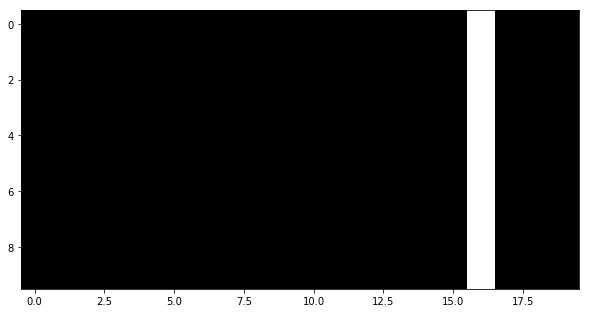

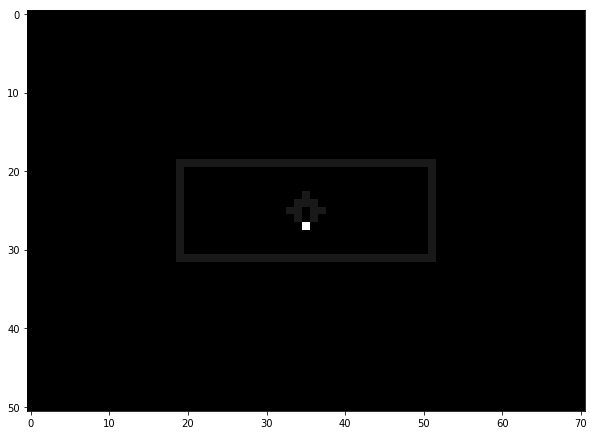

Agent 3's Observation Space:
Agent 3's Orientation: UP
Agent 3's Action: UP
Agent 3's Location: 35,27


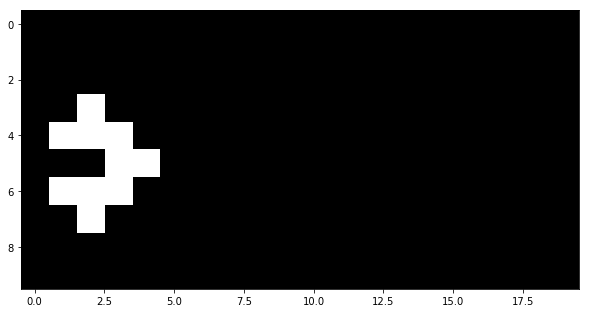

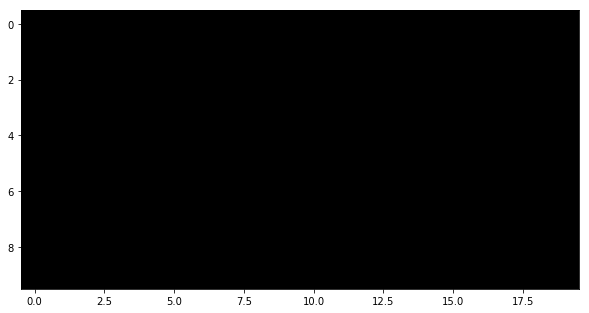

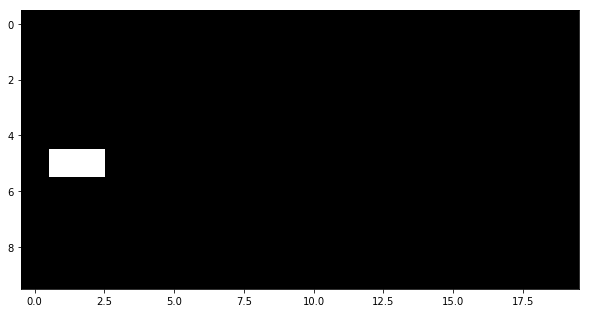

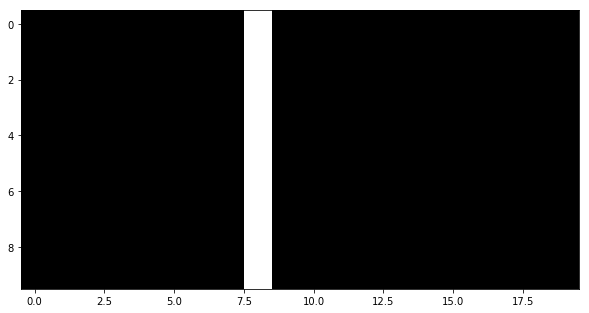

In [6]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

action=['UP','RIGHT','DOWN','LEFT']
np.set_printoptions(threshold=np.inf)

print(env.state_size)
print (env.agents)
print (env.orientations)

game_space = env.food + env.walls
print(game_space.shape)

game_space[env.agents[0]]=10
plt.imshow(game_space.T)
plt.show()

print (state_n.shape)

print ("Agent 1's Observation Space:")
print ("Agent 1's Orientation: {}".format(action[env.orientations[0]]))
print ("Agent 1's Action: {}".format(action[actions[0]]))
print ("Agent 1's Location: {},{}".format(env.agents[0][0], env.agents[0][1]))

observation1 = state_n[0].reshape(10,20,4)
plt.imshow(observation1[:, :, 0])
plt.show()

plt.imshow(observation1[:, :, 1])
plt.show()

plt.imshow(observation1[:, :, 2])
plt.show()

plt.imshow(observation1[:, :, 3])
plt.show()

game_space[env.agents[0]]=0
game_space[env.agents[1]]=10
plt.imshow(game_space.T)
plt.show()

print ("Agent 2's Observation Space:")
print ("Agent 2's Orientation: {}".format(action[env.orientations[1]]))
print ("Agent 2's Action: {}".format(action[actions[1]]))
print ("Agent 2's Location: {},{}".format(env.agents[1][0], env.agents[1][1]))

observation1 = state_n[1].reshape(10,20,4)
plt.imshow(observation1[:, :, 0])
plt.show()

plt.imshow(observation1[:, :, 1])
plt.show()

plt.imshow(observation1[:, :, 2])
plt.show()

plt.imshow(observation1[:, :, 3])
plt.show()

game_space[env.agents[0]]=0
game_space[env.agents[1]]=0
game_space[env.agents[2]]=10
plt.imshow(game_space.T)
plt.show()

print ("Agent 3's Observation Space:")
print ("Agent 3's Orientation: {}".format(action[env.orientations[2]]))
print ("Agent 3's Action: {}".format(action[actions[2]]))
print ("Agent 3's Location: {},{}".format(env.agents[2][0], env.agents[2][1]))

observation1 = state_n[2].reshape(10,20,4)
plt.imshow(observation1[:, :, 0])
plt.show()

plt.imshow(observation1[:, :, 1])
plt.show()

plt.imshow(observation1[:, :, 2])
plt.show()

plt.imshow(observation1[:, :, 3])
plt.show()

In [12]:
print(actions)

[5, 0, 0]


In [45]:
movement_n = [
                (0, -1),  # up/forward
                (1, 0),   # right
                (0, 1),   # down/backward
                (-1, 0),  # left
            ]
for move in movement_n:
    x, y = move
    print (x, y)

0 -1
1 0
0 1
-1 0


In [8]:
action1 = [5, 0, 0]
action2 = [10, 0, 0]

print([action1,action2])

[[5, 0, 0], [10, 0, 0]]


In [9]:
action1 = [5, 0, 0]
action2 = [10, 0, 0]
action = []

action.append(action1)
print (action)
action.append(action2)
print (action)

[[5, 0, 0]]
[[5, 0, 0], [10, 0, 0]]


In [11]:
print(action1+action2)

[5, 0, 0, 10, 0, 0]


In [9]:
os.path.exists("agent-4-model.pkl")

True

### Training Multiple NNs - 1

This is the most basic framework for training multiple NN. Here the NNs are totally separate, and each NN learns independently with separate datasets.

In [24]:
from torch.autograd import Variable


class TwoLayerNet(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(TwoLayerNet, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, D_out)

    def forward(self, x):
        """
        In the forward function we accept a Variable of input data and we must return
        a Variable of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Variables.
        """
        h_relu = self.linear1(x).clamp(min=0)
        y_pred = self.linear2(h_relu)
        return y_pred


# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 1000, 100, 10

# Create random Tensors to hold inputs and outputs, and wrap them in Variables
x1 = Variable(torch.randn(N, D_in))
y1 = Variable(torch.randn(N, D_out), requires_grad=False)
x2 = Variable(torch.randn(N, D_in))
y2 = Variable(torch.randn(N, D_out), requires_grad=False)


# Construct our model by instantiating the class defined above
model1 = TwoLayerNet(D_in, H, D_out)
model2 = TwoLayerNet(D_in, H, D_out)

# Construct our loss function and an Optimizer. The call to model.parameters()
# in the SGD constructor will contain the learnable parameters of the two
# nn.Linear modules which are members of the model.
criterion1 = torch.nn.MSELoss(size_average=False)
optimizer1 = torch.optim.SGD(model1.parameters(), lr=1e-4)

criterion2 = torch.nn.MSELoss(size_average=False)
optimizer2 = torch.optim.SGD(model2.parameters(), lr=1e-4)

for t in range(500):
    # Forward pass: Compute predicted y by passing x to the model
    y_pred1 = model1(x1)
    y_pred2 = model2(x2)

    # Compute and print loss
    loss1 = criterion(y_pred1, y1)
    loss2 = criterion(y_pred2, y2)
    print(t, loss1.data[0], loss2.data[0])

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer1.zero_grad()
    loss1.backward()
    optimizer1.step()
    
    optimizer2.zero_grad()
    loss2.backward()
    optimizer2.step()

0 633.7586669921875 777.9849853515625
1 585.9645385742188 719.013427734375
2 544.7007446289062 667.6548461914062
3 508.760986328125 622.6159057617188
4 477.0133972167969 582.5451049804688
5 448.34637451171875 546.59423828125
6 422.60357666015625 514.1270751953125
7 399.3191833496094 484.2102355957031
8 377.7106018066406 456.41351318359375
9 357.5779113769531 430.5800476074219
10 338.8116455078125 406.2713317871094
11 321.2728271484375 383.4058532714844
12 304.8344421386719 361.7463684082031
13 289.3735656738281 341.2002258300781
14 274.7208251953125 321.6092224121094
15 260.80517578125 302.99151611328125
16 247.5433349609375 285.3048095703125
17 234.88916015625 268.4383544921875
18 222.8232421875 252.4706573486328
19 211.3445587158203 237.30398559570312
20 200.42489624023438 222.90956115722656
21 189.98658752441406 209.28466796875
22 180.0203857421875 196.42300415039062
23 170.4871063232422 184.2354278564453
24 161.40802001953125 172.69847106933594
25 152.75747680664062 161.81213378906

322 0.0003138418833259493 0.0008696551667526364
323 0.00030308120767585933 0.0008453581249341369
324 0.000292719341814518 0.0008217587019316852
325 0.00028267898596823215 0.0007988351862877607
326 0.0002730231499299407 0.0007765698246657848
327 0.0002636894350871444 0.0007549366564489901
328 0.00025467504747211933 0.000733919907361269
329 0.00024596057482995093 0.0007134964689612389
330 0.00023755818256177008 0.0006936698919162154
331 0.00022944148804526776 0.0006744158454239368
332 0.00022161488595884293 0.000655686657410115
333 0.0002140512369805947 0.0006374967051669955
334 0.00020675052655860782 0.000619823404122144
335 0.00019969492859672755 0.0006026747869327664
336 0.00019289761257823557 0.0005859834491275251
337 0.0001863196084741503 0.0005697777960449457
338 0.00017997513350564986 0.000554037862457335
339 0.00017384483362548053 0.0005387343117035925
340 0.00016791549569461495 0.0005238717421889305
341 0.00016220459656324238 0.0005094282678328454
342 0.0001566801656736061 0.000

### Training Multiple NNs - 2

In this code block, the 2 NNs are learning with 2 optimizers towards a weighted sum of error. The training emphasized the data fitting of Model2 over Model1.

In [28]:
#from torch.autograd import Variable


class TwoLayerNet(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(TwoLayerNet, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, D_out)

    def forward(self, x):
        """
        In the forward function we accept a Variable of input data and we must return
        a Variable of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Variables.
        """
        h_relu = self.linear1(x).clamp(min=0)
        y_pred = self.linear2(h_relu)
        return y_pred


# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 1000, 100, 10

# Create random Tensors to hold inputs and outputs, and wrap them in Variables
x1 = Variable(torch.randn(N, D_in))
y1 = Variable(torch.randn(N, D_out), requires_grad=False)
x2 = Variable(torch.randn(N, D_in))
y2 = Variable(torch.randn(N, D_out), requires_grad=False)

# Construct our model by instantiating the class defined above
model1 = TwoLayerNet(D_in, H, D_out)
model2 = TwoLayerNet(D_in, H, D_out)

# Construct our loss function and an Optimizer. The call to model.parameters()
# in the SGD constructor will contain the learnable parameters of the two
# nn.Linear modules which are members of the model.
params = (list)
criterion = torch.nn.MSELoss(size_average=False)
optimizer1 = torch.optim.SGD(model1.parameters(), lr=1e-4)
optimizer2 = torch.optim.SGD(model2.parameters(), lr=1e-4)

for t in range(500):
    # Forward pass: Compute predicted y by passing x to the model
    y_pred1 = model1(x1)
    y_pred2 = model2(x2)

    # Compute and print loss
    loss1 = criterion(y_pred1, y1)
    loss2 = criterion(y_pred2, y2)
    loss = 1.0*loss1 + 2.0*loss2   # The higher weight --> greater fitting
    
    print(t, loss1.data[0], loss2.data[0], loss.data[0])

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer1.zero_grad()
    optimizer2.zero_grad()
    
    loss.backward()    # Backprop on loss - which is a weighted sum of loss1 and loss2
    
    optimizer1.step()
    optimizer2.step()


0 594.7704467773438 686.4010620117188 1967.572509765625
1 551.6640625 586.47412109375 1724.6123046875
2 514.5069580078125 511.9692687988281 1538.445556640625
3 481.9252014160156 453.1743469238281 1388.27392578125
4 452.84967041015625 404.1015319824219 1261.052734375
5 426.5615234375 361.7554016113281 1150.072265625
6 402.5431823730469 324.2408447265625 1051.02490234375
7 380.4490966796875 290.92535400390625 962.2998046875
8 360.2560729980469 260.5472412109375 881.3505859375
9 341.56781005859375 232.89231872558594 807.3524169921875
10 324.1141052246094 207.7465057373047 739.6071166992188
11 307.8088073730469 184.8883819580078 677.5855712890625
12 292.37786865234375 164.1835174560547 620.744873046875
13 277.7117919921875 145.32708740234375 568.365966796875
14 263.8661193847656 128.31539916992188 520.4969482421875
15 250.75906372070312 113.06564331054688 476.8903503417969
16 238.3601837158203 99.46428680419922 437.28875732421875
17 226.56414794921875 87.39651489257812 401.357177734375
18 

180 0.157793328166008 5.2191993745509535e-05 0.1578977108001709
181 0.15241114795207977 4.86662975163199e-05 0.15250848233699799
182 0.1472175121307373 4.53796710644383e-05 0.14730827510356903
183 0.14221271872520447 4.231498314766213e-05 0.14229734241962433
184 0.1373872309923172 3.945897697121836e-05 0.13746614754199982
185 0.1327352374792099 3.680469671962783e-05 0.1328088492155075
186 0.12825196981430054 3.433003803365864e-05 0.1283206343650818
187 0.12392782419919968 3.2015814213082194e-05 0.12399185448884964
188 0.11975573003292084 2.986440813401714e-05 0.11981546133756638
189 0.11572994291782379 2.786000186461024e-05 0.11578566581010818
190 0.11185193061828613 2.599074286990799e-05 0.11190391331911087
191 0.1081082820892334 2.4248076442745514e-05 0.10815677791833878
192 0.1044962927699089 2.262299858557526e-05 0.10454154014587402
193 0.10101122409105301 2.110616333084181e-05 0.10105343908071518
194 0.09764861315488815 1.969280856428668e-05 0.09768799692392349
195 0.0944036841392

329 0.0015493851387873292 2.8544124841545226e-09 0.0015493908431380987
330 0.0015058252029120922 2.712691182793492e-09 0.001505830674432218
331 0.0014635006664320827 2.582891678315491e-09 0.001463505788706243
332 0.0014224231708794832 2.465156079267672e-09 0.001422428060323
333 0.0013825080823153257 2.3434796325716434e-09 0.0013825127389281988
334 0.0013437579618766904 2.229349371773992e-09 0.0013437623856589198
335 0.001306110993027687 2.1342823064429695e-09 0.0013061153003945947
336 0.0012695828918367624 2.0386470289679437e-09 0.0012695869663730264
337 0.001234067720361054 1.948490924164048e-09 0.0012340715620666742
338 0.0011995721142739058 1.8535110113404585e-09 0.0011995758395642042
339 0.0011660514865070581 1.769863144929218e-09 0.001166054978966713
340 0.0011335352901369333 1.7047414591075949e-09 0.0011335386661812663
341 0.0011019294615834951 1.6204112496254197e-09 0.0011019327212125063
342 0.0010712083894759417 1.5565588817878506e-09 0.001071211532689631
343 0.0010413570562377

495 1.6781363228801638e-05 9.747200269139e-11 1.6781557860667817e-05
496 1.634359432500787e-05 9.642085740946271e-11 1.6343787137884647e-05
497 1.5918749340926297e-05 9.630626851553359e-11 1.5918942153803073e-05
498 1.5503555914619938e-05 9.48482542506568e-11 1.5503745089517906e-05
499 1.5101551070983987e-05 9.409842349761277e-11 1.5101739336387254e-05


In [5]:
print(env.observation_space.shape)

4


In [ ]:
from model import *    # Use the Policy and Rdn_policy defined in model.py

# There will be 4 agents - 3 AI agents, 1 random agent
num_ai_agents = 3
num_rdn_agents = 1
num_agents = num_ai_agents+num_rdn_agents  # just the sum of the two

# Data structure for AI agents (agents will form their own Class later on)
ai_agents = []
actions = []
tags = []
rewards = []

env = GatheringEnv(n_agents=num_agents, map_name='default')

# Env API is similar to that of OpenAI Gym
state_n = env.reset()
env.render()

# Load AI agents with trained weights
for i in range(num_ai_agents):
    print("Load agent {}".format(i))
    ai_agents.append(Policy(env.state_size, i+1))
    ai_agents[i].load_weights()
# Load random agents    
for i in range(num_ai_agents,num_agents):
    print("Load agent {}".format(i))
    ai_agents.append(Rdn_Policy())

# Initialize AI and random agent data
for i in range(num_agents):
    actions = [0 for i in range(num_agents)]
    tags = [0 for i in range(num_agents)]
    rewards = [0 for i in range(num_agents)]

n_steps = 1000

# Render for n_steps steps
for step in range(n_steps):
    # Load AI agent with trained weights
    for i in range(num_agents):
        actions[i] = ai_agents[i].select_action(state_n[i])
        if actions[i] is 6:
            tags[i] += 1   # record a tag for accessing aggressiveness

    if step % 10 == 0:
        print (actions)    
            
    state_n, reward_n, done_n, info_n = env.step(actions)

    for i in range(num_agents):
        rewards[i] += reward_n[i]    # Accumulate rewards for each agent
        
    if any(done_n):
        break
    env.render()
    time.sleep(1/30)  # Change speed of video rendering

env.close()  # Close the rendering window

# Print out statistics of all agents
for i in range(num_agents):
    print ("Agent{} aggressiveness is {:.2f}".format(i+1, tags[i]/n_steps))
    print ("Agent{} reward is {:d}".format(i+1, rewards[i]))

Load agent 0
Load agent 1
Load agent 2
Load agent 3
[4, 4, 4, 7]
[0, 4, 4, 6]
[0, 3, 4, 6]
[1, 1, 0, 0]
[4, 0, 0, 0]
[4, 7, 6, 3]
[6, 6, 0, 7]
[0, 2, 0, 2]
[0, 7, 0, 7]
[3, 1, 3, 0]
[6, 0, 6, 0]
[2, 1, 1, 5]
[1, 1, 6, 3]
[3, 1, 0, 1]
[0, 1, 3, 7]
[3, 5, 6, 3]
[6, 1, 5, 2]
[3, 6, 1, 1]
[3, 1, 0, 1]
[0, 1, 0, 7]
[6, 6, 1, 4]
[7, 0, 1, 5]
[7, 6, 1, 7]
[1, 0, 3, 2]
[6, 1, 0, 2]
[1, 6, 0, 0]
[6, 5, 3, 7]
[0, 4, 2, 5]
[4, 2, 0, 7]
[6, 1, 1, 4]
[0, 4, 6, 1]
[0, 1, 0, 4]
[3, 1, 6, 0]
[4, 2, 5, 6]
[6, 7, 0, 5]
[0, 1, 6, 2]
[2, 6, 5, 4]
[6, 0, 0, 7]
[4, 1, 3, 7]
[4, 6, 0, 0]
[0, 0, 7, 7]
[4, 0, 0, 3]
[1, 6, 0, 1]
[0, 5, 6, 3]
[4, 4, 5, 0]
[0, 6, 0, 5]
[7, 2, 0, 4]
[7, 0, 4, 4]
[0, 6, 1, 4]
[1, 6, 1, 0]
[6, 5, 4, 0]
[1, 1, 1, 4]
[4, 0, 6, 5]
[6, 6, 5, 6]
[7, 6, 5, 2]
[4, 1, 0, 3]
[6, 6, 5, 5]
[1, 6, 6, 4]
[6, 6, 0, 7]
[2, 6, 1, 7]
[6, 1, 6, 5]
[0, 5, 0, 3]
[6, 1, 5, 7]
[4, 1, 0, 3]
[4, 1, 0, 2]
[4, 1, 0, 7]
[5, 7, 5, 1]
[3, 0, 1, 1]
[7, 7, 0, 7]
